In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import numpy as np
%matplotlib inline

All columns have been split.
Before filling null values:
 USD (AM)      0
USD (PM)     36
GBP (AM)      0
GBP (PM)     36
EURO (AM)     0
EURO (PM)    36
dtype: int64
After filling null values:
 USD (AM)     0
USD (PM)     0
GBP (AM)     0
GBP (PM)     0
EURO (AM)    0
EURO (PM)    0
dtype: int64
Year, Month, and Day added to 'goldPrediction.csv'


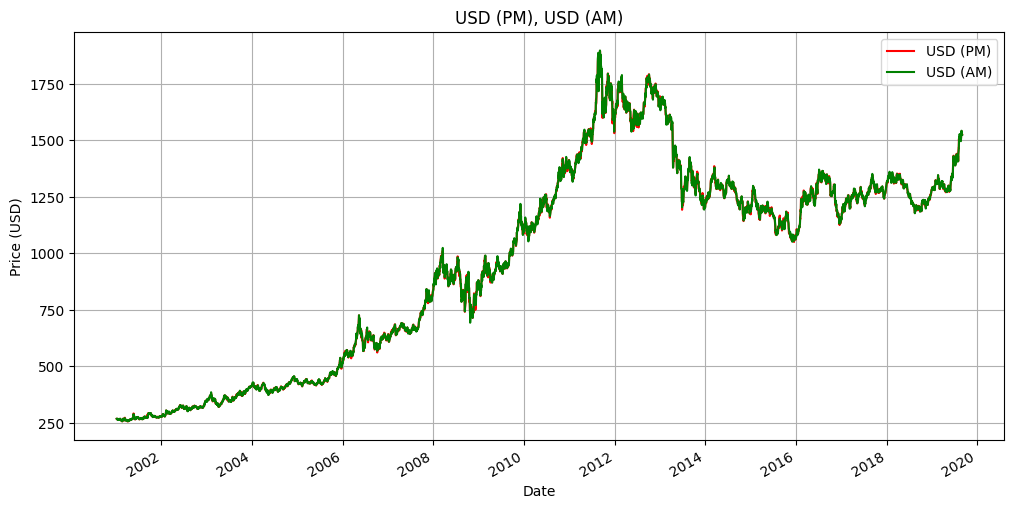

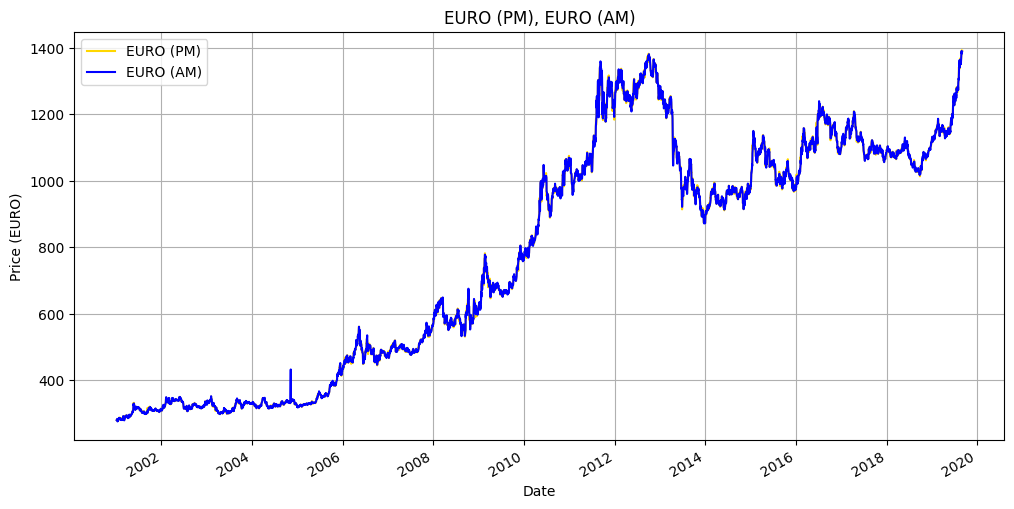

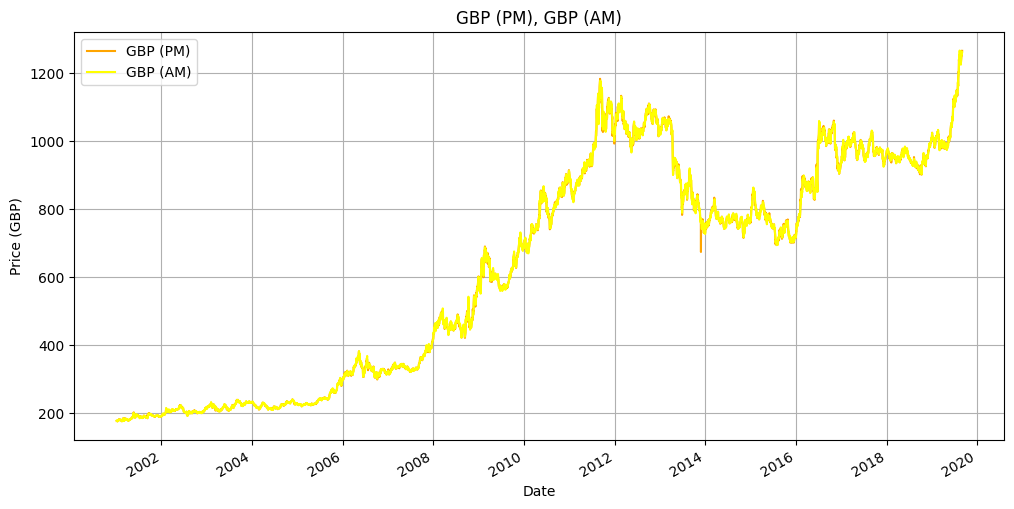

In [7]:
try:
    df = pd.read_csv('goldPrediction.csv', parse_dates=['Date'], index_col='Date')

    column_names = df.columns
    for i in range(len(column_names)): 
        current_col_name = column_names[i]
        single_column = df.iloc[:, i]
        file_name = f'{current_col_name}.txt'
        single_column.to_csv(file_name, index=True, header=False)
    print("All columns have been split.")

    print("Before filling null values:\n", df.isnull().sum())
    df.ffill(inplace=True)
    df.bfill(inplace=True)
    print("After filling null values:\n", df.isnull().sum())

    df["Year"] = df.index.year
    df["Month"] = df.index.month    
    df["Day"] = df.index.day

    df.to_csv('goldPrediction.csv', index=True)
    print("Year, Month, and Day added to 'goldPrediction.csv'")

    lags = 3 
    target_col = "USD (PM)"

    for i in range(1, lags + 1):
        df[f'{target_col}_lag_{i}'] = df[target_col].shift(i)

    other_cols = ["USD (AM)", "EURO (PM)"] 
    for col in other_cols:
        if col in df.columns:
            df[f'{col}_lag_1'] = df[col].shift(1)

    df.dropna(inplace=True)

    df[["USD (PM)", "USD (AM)"]].plot(
        kind='line',
        title='USD (PM), USD (AM)',
        linewidth=1.5,
        color=['red', 'green'],
        grid=True,            
        figsize=(12, 6),        
        ylabel='Price (USD)'
    )
    plt.show()

    df[["EURO (PM)", "EURO (AM)"]].plot(
        kind='line',
        title='EURO (PM), EURO (AM)',
        linewidth=1.5,
        color=['gold', 'blue'],
        grid=True,
        figsize=(12, 6),
        ylabel='Price (EURO)'
    )
    plt.show()

    df[["GBP (PM)", "GBP (AM)"]].plot(
        kind='line',
        title='GBP (PM), GBP (AM)',
        linewidth=1.5,
        color=['orange', 'yellow'],
        grid=True,
        figsize=(12, 6),
        ylabel='Price (GBP)'
    )
    plt.show()

except Exception as e:
    print(f"Error: {e}")

In [3]:
y = df[target_col] 
drop_cols = [col for col in df.columns if "lag" not in col and col not in ["Year", "Month", "Day", "DayOfWeek"]]
X = df.drop(columns=drop_cols)

print("Used Features:", X.columns.tolist())

print("Target size:", y.shape)
print("Features size:", X.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

print(f"Training set: {X_train.shape} (Past)")
print(f"Test set: {X_test.shape} (Future)")

Used Features: ['Year', 'Month', 'Day', 'USD (PM)_lag_1', 'USD (PM)_lag_2', 'USD (PM)_lag_3', 'USD (AM)_lag_1', 'EURO (PM)_lag_1']
Target size: (4715,)
Features size: (4715, 8)
Training set: (3772, 8) (Past)
Test set: (943, 8) (Future)


In [ ]:
models = {
        "Linear Regression": LinearRegression(),
        "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10),
        "XGBoost": xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, seed=42, learning_rate=0.05), 
    }
results_rmse = {}
results_mae = {}
results_r2 = {}
predictions = {}

Linear Regression Results:
  RMSE: 9.9283
  MAE: 7.1221
  R²: 0.9818
------------------------------
Random Forest Results:
  RMSE: 12.0889
  MAE: 8.6694
  R²: 0.9731
------------------------------
XGBoost Results:
  RMSE: 13.0023
  MAE: 9.6874
  R²: 0.9689
------------------------------


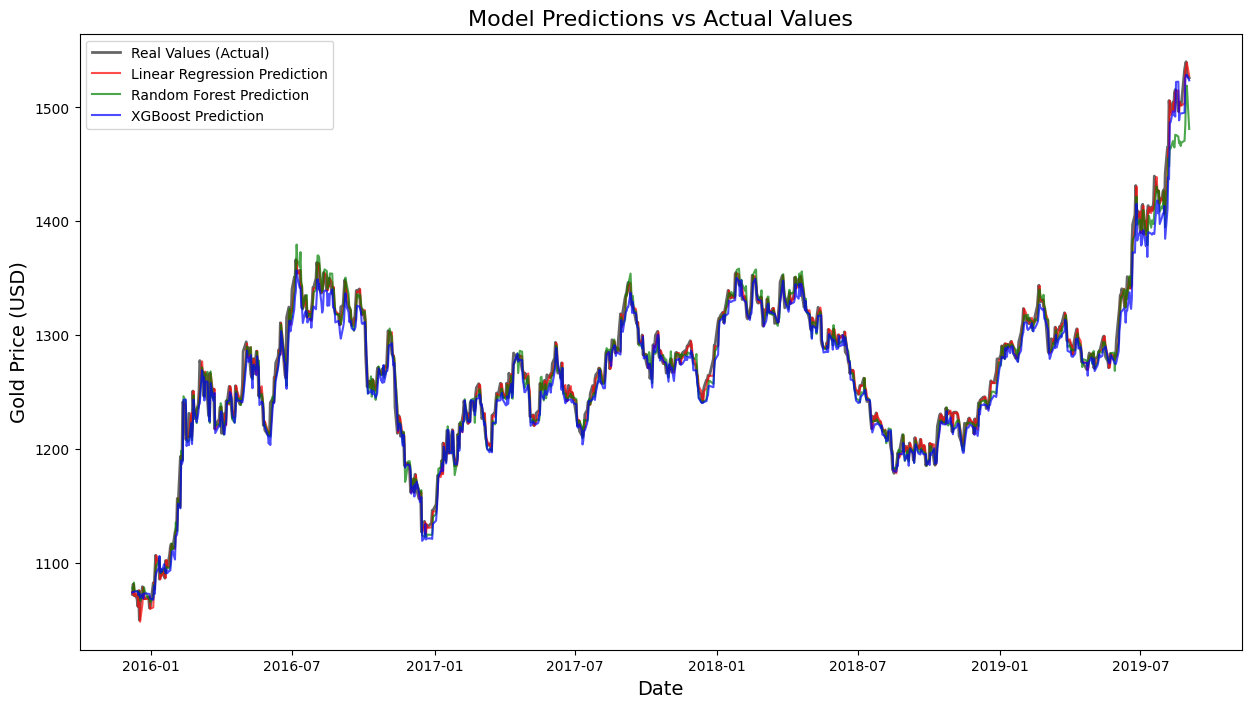

In [ ]:
plt.figure(figsize=(15, 8))

plt.plot(y_test.index, y_test, label='Real Values (Actual)', color='black', linewidth=2, alpha=0.6)

colors = ['red', 'green', 'blue']

for i, (name, model) in enumerate(models.items()):

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    predictions[name] = y_pred

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results_rmse[name] = rmse
    results_mae[name] = mae
    results_r2[name] = r2

    plt.plot(y_test.index, y_pred, label=f'{name} Prediction', color=colors[i], alpha=0.7)
    plt.title('Model Predictions vs Actual Values', fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Gold Price (USD)', fontsize=14)
    plt.legend()


    print(f"{name} Results:")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE: {mae:.4f}")
    print(f"  R²: {r2:.4f}")
    print("-" * 30)

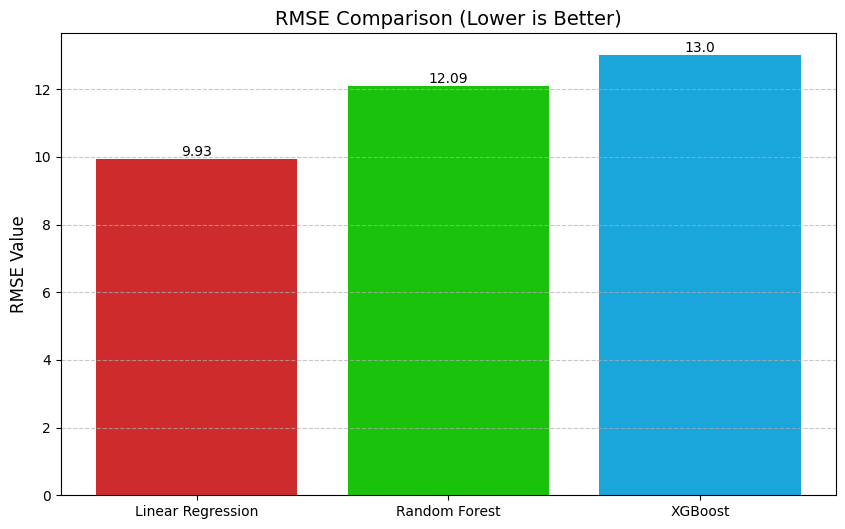

In [ ]:
plt.figure(figsize=(10, 6))

model_names = list(results_rmse.keys())
rmse_values = list(results_rmse.values())

bars = plt.bar(model_names, rmse_values, color=["#ce2c2c", "#1ac20b", "#1aa5db"])

plt.title('RMSE Comparison (Lower is Better)', fontsize=14)
plt.ylabel('RMSE Value', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, round(height, 2), ha='center', va='bottom')

plt.show()

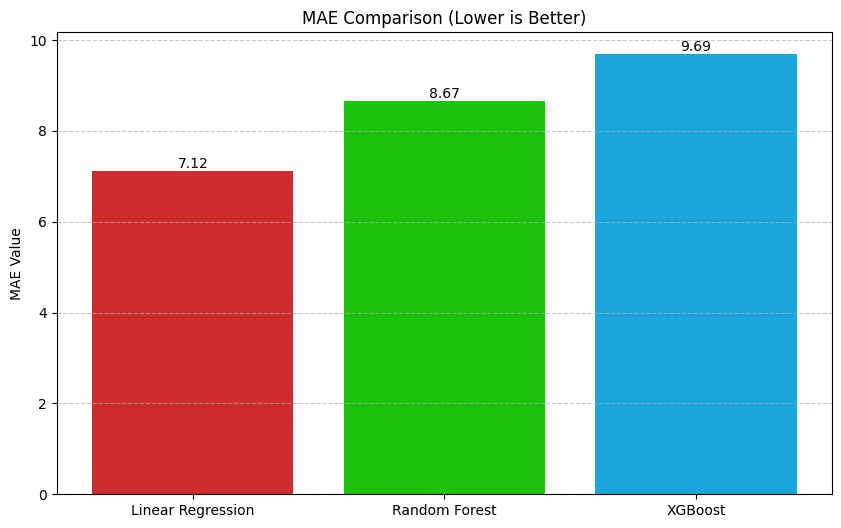

In [ ]:
plt.figure(figsize=(10, 6))

model_names = list(results_mae.keys())
mae_values = list(results_mae.values())

bars = plt.bar(model_names, mae_values, color=["#ce2c2c", "#1ac20b", "#1aa5db"])

plt.title('MAE Comparison (Lower is Better)')
plt.ylabel('MAE Value')
plt.grid(axis='y', linestyle='--', alpha=0.7)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

plt.show()

[0.9818410347925302, 0.9730770909326789, 0.9688553380172275]


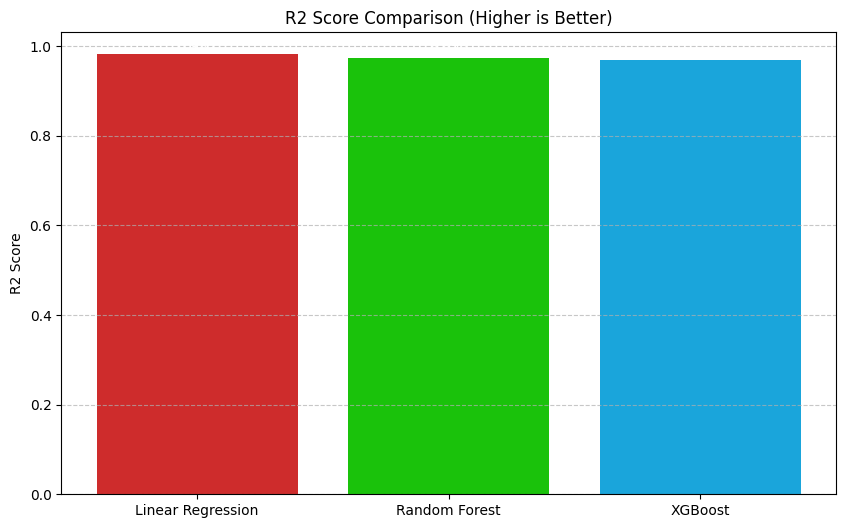

In [ ]:
plt.figure(figsize=(10, 6))

r2_values = list(results_r2.values())
print(r2_values)

bars = plt.bar(model_names, r2_values, color=["#ce2c2c", "#1ac20b", "#1aa5db"])

plt.title('R2 Score Comparison (Higher is Better)')
plt.ylabel('R2 Score')
plt.grid(axis='y', linestyle='--', alpha=0.7)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 3), ha='center', va='bottom', color='white')
plt.show()

İlk önce veri setinin son yüzde yirmisini yani 2016-2019 yılları arasını tahmin etmek için ayırdım. Modelin 2001-2016 arasına bakarak son 3 yılı tahmin etmesi gerekiyordu. Herhangi bir ek işlem yapmadan sadece seti böldüm ve regresyon modellerine bu setleri verdim. Lineer regresyon çok ezici bir şekilde daha iyi çıktı ve bu bana çok saçma geldi. Yapay zekaya sordum ve bana hedef olarak seçilen USD (PM) (Öğleden sonra fiyatı) hariç her şeyi özellik (feature) olarak aldığımı ancak veri setinde USD (AM) (Sabah fiyatı) veya aynı günün diğer para birimlerinin (EURO, GBP) de var olduğunu bu nedenle de modelin bir nevi kopya çektiğini söyledi. Lineer regresyonun bu veri setinde diğer karmaşık modelleri (XGBoost, Random Forest) geride bırakmasının temel nedeninin, altın gibi finansal varlıkların fiyatlarının genellikle bir önceki günün fiyatına çok güçlü ve doğrusal bir şekilde bağlı olması ve zaman içinde yukarı yönlü net bir trend izlemesi olduğunu söyledi. Lineer regresyon, bu basit matematiksel ilişkiyi (y = ax + b) ve genel artış eğimini yakalayıp geleceğe doğru sonsuza kadar uzatabilirken ağaç tabanlı modeller (Random Forest, XGBoost) yapıları gereği eğitim verisinde gördükleri maksimum ve minimum değerlerin dışına çıkamıyorlarmış (extrapolation sorunu).

Kodu şu anki haline getirdim yani gelecek verilerini çıkarttım ve hedefi bir sonraki günü tahmin edecek şekilde ayarladım. Sonra sonuç değişmedi hala lineer regresyon daha iyiydi ama aralarındaki fark biraz daha azaldı.

-fillna(method='ffill') hata veriyordu bunu kullanmadım o yüzden.
-Kod her kur için (am pm ayrı ayrı) veri dosyası oluşturuyor. Feature engineering için ise csv dosyasının sonuna yıl ay gün verilerini ekliyor. Bir kere çalıştırdıktan sonra null veriler temizleniyor. Sonraki çalıştırmalarda 0 gözüküyor o sebeple.